# Q3: Study the Neural Collapse phenomenon


## Setup

In [1]:
# Mount Google Drive (for saving checkpoints)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Clone repository
import os
if not os.path.exists('/content/OOD-Detection-Project---CSC_5IA23'):
    !git clone https://github.com/DiegoFleury/OOD-Detection-Project---CSC_5IA23/tree/contente/
%cd /content/OOD-Detection-Project---CSC_5IA23

/content/OOD-Detection-Project---CSC_5IA23


In [3]:
# Install dependencies
!pip install -q torch torchvision matplotlib seaborn scikit-learn pyyaml imageio tqdm

In [4]:
# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import yaml

from src.models import ResNet18
from src.data import get_cifar100_loaders
from src.utils import Trainer, plot_training_curves, create_training_gif, plot_final_metrics

# Check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


In [5]:
# Load config
with open('configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Configuration:")
print(yaml.dump(config, default_flow_style=False))

Configuration:
data:
  augment: true
  data_dir: ./data
  num_workers: 2
device: cuda
model:
  num_classes: 100
ood:
  datasets:
  - SVHN
paths:
  checkpoints: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints
  figures: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures
  gifs: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/gifs
  metrics: /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics
  results: /content/drive/MyDrive/Colab Notebooks/OOD/Results
  tables: /content/drive/MyDrive/Colab Notebooks/OOD/Results/tables
training:
  batch_size: 128
  checkpoint_frequency: 25
  early_stopping_patience: 999
  epochs: 300
  lr: 0.1
  momentum: 0.9
  val_split: 0.1
  weight_decay: 0.0005



## 1. Load Data

In [6]:
print("Loading CIFAR-100 dataset...")

train_loader, val_loader, test_loader = get_cifar100_loaders(
    data_dir=config['data']['data_dir'],
    batch_size=config['training']['batch_size'],
    num_workers=config['data']['num_workers'],
    augment=config['data']['augment'],
    val_split=config['training']['val_split']
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Loading CIFAR-100 dataset...
Train batches: 352
Val batches: 40
Test batches: 79


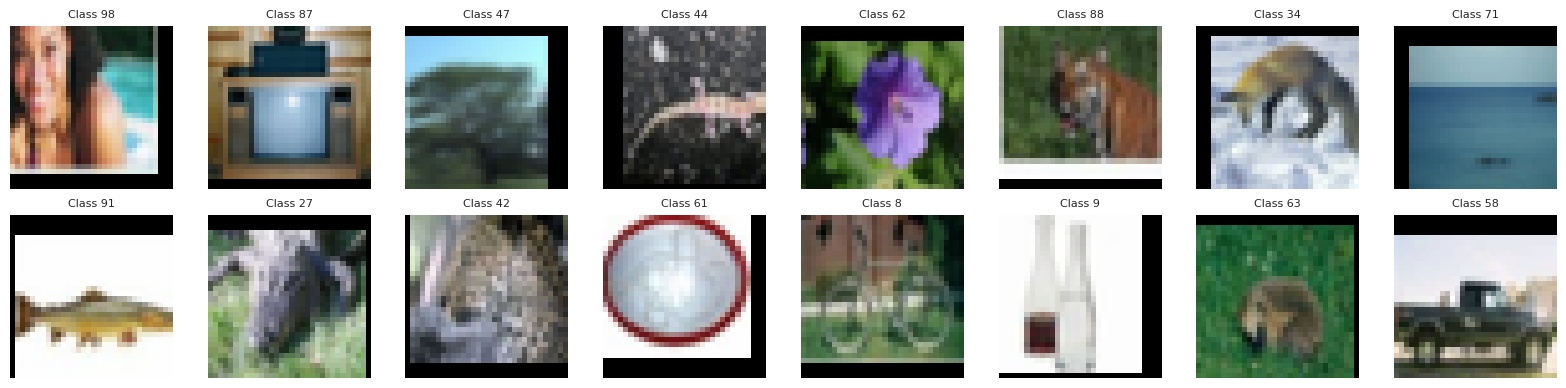

In [7]:
# Visualize sample batch
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).numpy()
    # Denormalize
    img = img * np.array([0.2675, 0.2565, 0.2761]) + np.array([0.5071, 0.4867, 0.4408])
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Class {labels[i].item()}", fontsize=8)

plt.tight_layout()

sample_batch_path = os.path.join(config['paths']['figures'], 'training', 'sample_batch.png')
plt.savefig(sample_batch_path, dpi=150, bbox_inches='tight')
plt.show()

## 2. Create Model

In [8]:
print("Creating ResNet-18 model...")

model = ResNet18(num_classes=config['model']['num_classes'])

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test forward pass
x_test = torch.randn(2, 3, 32, 32)
with torch.no_grad():
    out = model(x_test)
print(f"Output shape: {out.shape}")

Creating ResNet-18 model...
Total parameters: 11,220,132
Trainable parameters: 11,220,132
Output shape: torch.Size([2, 100])


## 3. Train Model

In [ ]:
# 3. Train or resume from checkpoint
import glob
import re
import os

checkpoint_dir = config['paths']['checkpoints']
checkpoints = glob.glob(os.path.join(checkpoint_dir, 'resnet18_cifar100_*.pth'))

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    lr=config['training']['lr'],
    momentum=config['training']['momentum'],
    weight_decay=config['training']['weight_decay'],
    device=device
)

if checkpoints:
    # Extract epoch number from checkpoint filename
    def get_epoch_num(path):
        match = re.search(r'epoch(\d+)', path)
        if match:
            return int(match.group(1))
        return 0

    # Get checkpoint with highest epoch number
    latest = max(checkpoints, key=get_epoch_num)
    epoch_num = get_epoch_num(latest)

    print(f"Resuming from: {os.path.basename(latest)} (epoch {epoch_num})")
    trainer.load_checkpoint(latest)

    epochs_done = len(trainer.history.get('train_loss', []))
    epochs_left = max(0, config['training']['epochs'] - epochs_done)
    print(f"Epoch {epochs_done}/{config['training']['epochs']} | Best val: {trainer.best_val_acc:.2f}%")
else:
    print("Starting fresh training")
    epochs_left = config['training']['epochs']

if epochs_left > 0:
    history = trainer.train(
        epochs=epochs_left,
        save_dir=checkpoint_dir,
        early_stopping_patience=config['training']['early_stopping_patience'],
        checkpoint_frequency=config['training']['checkpoint_frequency']
    )
else:
    print("Already trained!")
    history = trainer.history

print("\n" + "="*50)
print("Training finished!")
print("="*50)


Starting fresh training

Epoch 1/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.81it/s, loss=3.76, acc=11.7]



Train Loss: 4.0527 | Train Acc: 7.41%
Val Loss: 3.6771 | Val Acc: 11.52%
Test Acc: 11.69%
LR: 0.099997
✓ New best validation accuracy: 11.52%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 2/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.54it/s, loss=3.47, acc=18.2]



Train Loss: 3.4798 | Train Acc: 15.54%
Val Loss: 3.3122 | Val Acc: 18.84%
Test Acc: 18.21%
LR: 0.099989
✓ New best validation accuracy: 18.84%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 3/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.99it/s, loss=3.16, acc=26.7]



Train Loss: 2.9685 | Train Acc: 25.06%
Val Loss: 2.9141 | Val Acc: 26.92%
Test Acc: 26.74%
LR: 0.099975
✓ New best validation accuracy: 26.92%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 4/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.78it/s, loss=2.68, acc=33.3]



Train Loss: 2.4927 | Train Acc: 34.23%
Val Loss: 2.6031 | Val Acc: 33.32%
Test Acc: 33.31%
LR: 0.099956
✓ New best validation accuracy: 33.32%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 5/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 61.48it/s, loss=2.51, acc=39.7]



Train Loss: 2.1568 | Train Acc: 41.49%
Val Loss: 2.3687 | Val Acc: 39.34%
Test Acc: 39.72%
LR: 0.099931
✓ New best validation accuracy: 39.34%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 6/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 54.89it/s, loss=2.25, acc=43.5]



Train Loss: 1.9225 | Train Acc: 46.80%
Val Loss: 2.0909 | Val Acc: 42.70%
Test Acc: 43.45%
LR: 0.099901
✓ New best validation accuracy: 42.70%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 7/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.56it/s, loss=2.33, acc=41.8]



Train Loss: 1.7663 | Train Acc: 50.55%
Val Loss: 2.1903 | Val Acc: 42.88%
Test Acc: 41.75%
LR: 0.099866
✓ New best validation accuracy: 42.88%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 8/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.33it/s, loss=2.1, acc=47.4]



Train Loss: 1.6581 | Train Acc: 53.19%
Val Loss: 1.9573 | Val Acc: 47.60%
Test Acc: 47.38%
LR: 0.099825
✓ New best validation accuracy: 47.60%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 9/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 61.15it/s, loss=2.06, acc=45.5]



Train Loss: 1.5742 | Train Acc: 55.35%
Val Loss: 2.0662 | Val Acc: 45.62%
Test Acc: 45.51%
LR: 0.099778

Epoch 10/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 52.84it/s, loss=2.61, acc=41.8]



Train Loss: 1.5056 | Train Acc: 57.00%
Val Loss: 2.3194 | Val Acc: 42.88%
Test Acc: 41.84%
LR: 0.099726

Epoch 11/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 61.26it/s, loss=1.8, acc=52.5]



Train Loss: 1.4512 | Train Acc: 58.48%
Val Loss: 1.7111 | Val Acc: 53.36%
Test Acc: 52.53%
LR: 0.099669
✓ New best validation accuracy: 53.36%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 12/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.94it/s, loss=1.76, acc=54.2]



Train Loss: 1.4017 | Train Acc: 59.96%
Val Loss: 1.6516 | Val Acc: 55.22%
Test Acc: 54.21%
LR: 0.099606
✓ New best validation accuracy: 55.22%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 13/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.35it/s, loss=1.97, acc=51.4]



Train Loss: 1.3563 | Train Acc: 60.91%
Val Loss: 1.7966 | Val Acc: 51.74%
Test Acc: 51.42%
LR: 0.099537

Epoch 14/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.80it/s, loss=2.09, acc=49.5]



Train Loss: 1.3315 | Train Acc: 61.50%
Val Loss: 1.8860 | Val Acc: 49.34%
Test Acc: 49.47%
LR: 0.099464

Epoch 15/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.81it/s, loss=1.87, acc=53.4]



Train Loss: 1.2870 | Train Acc: 62.56%
Val Loss: 1.7439 | Val Acc: 53.82%
Test Acc: 53.40%
LR: 0.099384

Epoch 16/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.09it/s, loss=1.71, acc=54.9]



Train Loss: 1.2660 | Train Acc: 63.44%
Val Loss: 1.6848 | Val Acc: 55.04%
Test Acc: 54.88%
LR: 0.099300

Epoch 17/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.88it/s, loss=1.8, acc=55.2]



Train Loss: 1.2382 | Train Acc: 63.97%
Val Loss: 1.6587 | Val Acc: 54.98%
Test Acc: 55.24%
LR: 0.099210

Epoch 18/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.81it/s, loss=1.86, acc=55.3]



Train Loss: 1.2152 | Train Acc: 64.65%
Val Loss: 1.6916 | Val Acc: 54.90%
Test Acc: 55.31%
LR: 0.099114

Epoch 19/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.99it/s, loss=1.89, acc=53.7]



Train Loss: 1.1984 | Train Acc: 65.14%
Val Loss: 1.7215 | Val Acc: 54.28%
Test Acc: 53.69%
LR: 0.099014

Epoch 20/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.47it/s, loss=1.65, acc=57.2]



Train Loss: 1.1808 | Train Acc: 65.82%
Val Loss: 1.6142 | Val Acc: 57.34%
Test Acc: 57.22%
LR: 0.098907
✓ New best validation accuracy: 57.34%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 21/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.97it/s, loss=1.83, acc=54.5]



Train Loss: 1.1714 | Train Acc: 65.74%
Val Loss: 1.7281 | Val Acc: 53.94%
Test Acc: 54.46%
LR: 0.098796

Epoch 22/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 61.07it/s, loss=1.71, acc=57.1]



Train Loss: 1.1483 | Train Acc: 66.29%
Val Loss: 1.6190 | Val Acc: 56.64%
Test Acc: 57.10%
LR: 0.098679

Epoch 23/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.73it/s, loss=1.77, acc=56.6]



Train Loss: 1.1296 | Train Acc: 67.15%
Val Loss: 1.5964 | Val Acc: 56.92%
Test Acc: 56.64%
LR: 0.098557

Epoch 24/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.31it/s, loss=1.7, acc=55.4]



Train Loss: 1.1269 | Train Acc: 67.24%
Val Loss: 1.6809 | Val Acc: 54.80%
Test Acc: 55.38%
LR: 0.098429

Epoch 25/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.64it/s, loss=2.15, acc=48.7]



Train Loss: 1.1058 | Train Acc: 67.64%
Val Loss: 2.0970 | Val Acc: 48.94%
Test Acc: 48.66%
LR: 0.098296
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch25.pth

Epoch 26/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.26it/s, loss=1.88, acc=53.1]



Train Loss: 1.0996 | Train Acc: 67.91%
Val Loss: 1.7926 | Val Acc: 52.22%
Test Acc: 53.14%
LR: 0.098158

Epoch 27/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.31it/s, loss=1.67, acc=58.4]



Train Loss: 1.0884 | Train Acc: 68.45%
Val Loss: 1.5533 | Val Acc: 58.56%
Test Acc: 58.44%
LR: 0.098015
✓ New best validation accuracy: 58.56%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 28/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.10it/s, loss=1.82, acc=54.3]



Train Loss: 1.0679 | Train Acc: 68.86%
Val Loss: 1.7743 | Val Acc: 55.36%
Test Acc: 54.26%
LR: 0.097866

Epoch 29/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 61.82it/s, loss=1.79, acc=56.7]



Train Loss: 1.0774 | Train Acc: 68.42%
Val Loss: 1.6768 | Val Acc: 56.08%
Test Acc: 56.74%
LR: 0.097712

Epoch 30/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.15it/s, loss=1.92, acc=53.6]



Train Loss: 1.0554 | Train Acc: 69.04%
Val Loss: 1.7878 | Val Acc: 54.48%
Test Acc: 53.58%
LR: 0.097553

Epoch 31/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.09it/s, loss=1.65, acc=59.3]



Train Loss: 1.0585 | Train Acc: 69.13%
Val Loss: 1.4794 | Val Acc: 60.02%
Test Acc: 59.30%
LR: 0.097388
✓ New best validation accuracy: 60.02%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 32/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.14it/s, loss=1.81, acc=55.9]



Train Loss: 1.0466 | Train Acc: 69.31%
Val Loss: 1.6417 | Val Acc: 55.60%
Test Acc: 55.85%
LR: 0.097219

Epoch 33/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 52.19it/s, loss=1.65, acc=59.1]



Train Loss: 1.0321 | Train Acc: 69.91%
Val Loss: 1.5395 | Val Acc: 59.68%
Test Acc: 59.06%
LR: 0.097044

Epoch 34/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.10it/s, loss=1.62, acc=58.9]



Train Loss: 1.0307 | Train Acc: 69.81%
Val Loss: 1.5123 | Val Acc: 58.58%
Test Acc: 58.94%
LR: 0.096864

Epoch 35/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.13it/s, loss=1.7, acc=57.5]



Train Loss: 1.0178 | Train Acc: 70.18%
Val Loss: 1.6260 | Val Acc: 56.58%
Test Acc: 57.49%
LR: 0.096679

Epoch 36/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 53.89it/s, loss=1.68, acc=56.6]



Train Loss: 1.0141 | Train Acc: 70.32%
Val Loss: 1.6261 | Val Acc: 56.70%
Test Acc: 56.57%
LR: 0.096489

Epoch 37/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.42it/s, loss=1.83, acc=57]



Train Loss: 1.0016 | Train Acc: 70.53%
Val Loss: 1.6978 | Val Acc: 57.62%
Test Acc: 57.01%
LR: 0.096294

Epoch 38/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.99it/s, loss=1.57, acc=59.4]



Train Loss: 1.0039 | Train Acc: 70.55%
Val Loss: 1.5056 | Val Acc: 59.12%
Test Acc: 59.39%
LR: 0.096093

Epoch 39/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.36it/s, loss=1.76, acc=57.7]



Train Loss: 1.0102 | Train Acc: 70.20%
Val Loss: 1.5762 | Val Acc: 57.34%
Test Acc: 57.69%
LR: 0.095888

Epoch 40/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.72it/s, loss=1.93, acc=54.8]



Train Loss: 0.9980 | Train Acc: 70.56%
Val Loss: 1.7599 | Val Acc: 54.54%
Test Acc: 54.80%
LR: 0.095677

Epoch 41/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.30it/s, loss=1.72, acc=57.8]



Train Loss: 0.9859 | Train Acc: 70.65%
Val Loss: 1.6368 | Val Acc: 57.66%
Test Acc: 57.77%
LR: 0.095462

Epoch 42/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 54.98it/s, loss=1.65, acc=58.5]



Train Loss: 0.9839 | Train Acc: 71.05%
Val Loss: 1.5720 | Val Acc: 58.84%
Test Acc: 58.48%
LR: 0.095241

Epoch 43/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.27it/s, loss=1.6, acc=58.4]



Train Loss: 0.9815 | Train Acc: 71.24%
Val Loss: 1.5744 | Val Acc: 58.36%
Test Acc: 58.37%
LR: 0.095016

Epoch 44/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.61it/s, loss=2.05, acc=53]



Train Loss: 0.9685 | Train Acc: 71.40%
Val Loss: 1.8443 | Val Acc: 53.68%
Test Acc: 53.02%
LR: 0.094786

Epoch 45/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.56it/s, loss=1.84, acc=55.6]



Train Loss: 0.9632 | Train Acc: 71.56%
Val Loss: 1.6588 | Val Acc: 56.36%
Test Acc: 55.61%
LR: 0.094550

Epoch 46/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.29it/s, loss=1.69, acc=57.8]



Train Loss: 0.9629 | Train Acc: 71.31%
Val Loss: 1.6423 | Val Acc: 57.08%
Test Acc: 57.79%
LR: 0.094310

Epoch 47/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.85it/s, loss=1.64, acc=58.3]



Train Loss: 0.9580 | Train Acc: 71.76%
Val Loss: 1.6298 | Val Acc: 58.34%
Test Acc: 58.28%
LR: 0.094065

Epoch 48/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.67it/s, loss=1.77, acc=56.3]



Train Loss: 0.9395 | Train Acc: 72.30%
Val Loss: 1.7318 | Val Acc: 56.78%
Test Acc: 56.30%
LR: 0.093815

Epoch 49/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.71it/s, loss=1.78, acc=56.6]



Train Loss: 0.9475 | Train Acc: 71.98%
Val Loss: 1.7581 | Val Acc: 55.62%
Test Acc: 56.56%
LR: 0.093561

Epoch 50/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.87it/s, loss=1.75, acc=58]



Train Loss: 0.9395 | Train Acc: 72.16%
Val Loss: 1.6617 | Val Acc: 57.38%
Test Acc: 57.98%
LR: 0.093301
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch50.pth

Epoch 51/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.86it/s, loss=1.7, acc=57.4]



Train Loss: 0.9417 | Train Acc: 72.01%
Val Loss: 1.6559 | Val Acc: 57.20%
Test Acc: 57.37%
LR: 0.093037

Epoch 52/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.44it/s, loss=1.57, acc=59.7]



Train Loss: 0.9377 | Train Acc: 72.18%
Val Loss: 1.4924 | Val Acc: 60.36%
Test Acc: 59.68%
LR: 0.092768
✓ New best validation accuracy: 60.36%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 53/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.60it/s, loss=1.89, acc=57.2]



Train Loss: 0.9320 | Train Acc: 72.37%
Val Loss: 1.6844 | Val Acc: 57.90%
Test Acc: 57.16%
LR: 0.092495

Epoch 54/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.30it/s, loss=1.82, acc=56.7]



Train Loss: 0.9201 | Train Acc: 72.60%
Val Loss: 1.6960 | Val Acc: 57.68%
Test Acc: 56.74%
LR: 0.092216

Epoch 55/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.27it/s, loss=1.74, acc=57.5]



Train Loss: 0.9243 | Train Acc: 72.55%
Val Loss: 1.6637 | Val Acc: 56.66%
Test Acc: 57.48%
LR: 0.091934

Epoch 56/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.89it/s, loss=1.78, acc=57.5]



Train Loss: 0.9174 | Train Acc: 72.49%
Val Loss: 1.6451 | Val Acc: 58.22%
Test Acc: 57.48%
LR: 0.091646

Epoch 57/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.33it/s, loss=1.71, acc=58.8]



Train Loss: 0.8969 | Train Acc: 73.39%
Val Loss: 1.5582 | Val Acc: 59.92%
Test Acc: 58.75%
LR: 0.091354

Epoch 58/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.01it/s, loss=1.85, acc=56]



Train Loss: 0.9098 | Train Acc: 72.87%
Val Loss: 1.7685 | Val Acc: 56.52%
Test Acc: 56.00%
LR: 0.091057

Epoch 59/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.77it/s, loss=1.7, acc=59.6]



Train Loss: 0.8972 | Train Acc: 73.46%
Val Loss: 1.5249 | Val Acc: 60.14%
Test Acc: 59.56%
LR: 0.090756

Epoch 60/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.70it/s, loss=1.89, acc=54.8]



Train Loss: 0.9039 | Train Acc: 73.15%
Val Loss: 1.7516 | Val Acc: 56.32%
Test Acc: 54.81%
LR: 0.090451

Epoch 61/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.35it/s, loss=1.67, acc=58.6]



Train Loss: 0.9127 | Train Acc: 72.97%
Val Loss: 1.6184 | Val Acc: 58.96%
Test Acc: 58.64%
LR: 0.090141

Epoch 62/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.99it/s, loss=1.61, acc=60.4]



Train Loss: 0.8909 | Train Acc: 73.57%
Val Loss: 1.5714 | Val Acc: 60.70%
Test Acc: 60.42%
LR: 0.089826
✓ New best validation accuracy: 60.70%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 63/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.24it/s, loss=1.8, acc=56.1]



Train Loss: 0.8832 | Train Acc: 73.52%
Val Loss: 1.7887 | Val Acc: 56.46%
Test Acc: 56.08%
LR: 0.089508

Epoch 64/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.75it/s, loss=1.59, acc=59.3]



Train Loss: 0.8841 | Train Acc: 73.73%
Val Loss: 1.5577 | Val Acc: 60.16%
Test Acc: 59.33%
LR: 0.089185

Epoch 65/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.08it/s, loss=1.59, acc=60.1]



Train Loss: 0.8849 | Train Acc: 73.75%
Val Loss: 1.4856 | Val Acc: 60.32%
Test Acc: 60.15%
LR: 0.088857

Epoch 66/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.69it/s, loss=1.74, acc=56.8]



Train Loss: 0.8752 | Train Acc: 73.93%
Val Loss: 1.6500 | Val Acc: 57.12%
Test Acc: 56.82%
LR: 0.088526

Epoch 67/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.02it/s, loss=1.57, acc=60]



Train Loss: 0.8689 | Train Acc: 74.12%
Val Loss: 1.5840 | Val Acc: 59.22%
Test Acc: 59.97%
LR: 0.088190

Epoch 68/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.93it/s, loss=1.61, acc=59.2]



Train Loss: 0.8682 | Train Acc: 74.32%
Val Loss: 1.5255 | Val Acc: 59.52%
Test Acc: 59.17%
LR: 0.087850

Epoch 69/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.23it/s, loss=1.66, acc=59.5]



Train Loss: 0.8664 | Train Acc: 74.33%
Val Loss: 1.5230 | Val Acc: 60.18%
Test Acc: 59.46%
LR: 0.087506

Epoch 70/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.64it/s, loss=1.78, acc=59.1]



Train Loss: 0.8576 | Train Acc: 74.36%
Val Loss: 1.6771 | Val Acc: 58.06%
Test Acc: 59.06%
LR: 0.087157

Epoch 71/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.45it/s, loss=1.73, acc=59.1]



Train Loss: 0.8472 | Train Acc: 74.49%
Val Loss: 1.5740 | Val Acc: 59.14%
Test Acc: 59.13%
LR: 0.086805

Epoch 72/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.65it/s, loss=1.69, acc=58.7]



Train Loss: 0.8491 | Train Acc: 74.45%
Val Loss: 1.6462 | Val Acc: 58.86%
Test Acc: 58.67%
LR: 0.086448

Epoch 73/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.41it/s, loss=2.03, acc=53.2]



Train Loss: 0.8440 | Train Acc: 74.83%
Val Loss: 1.8118 | Val Acc: 54.22%
Test Acc: 53.22%
LR: 0.086088

Epoch 74/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.43it/s, loss=1.6, acc=59.4]



Train Loss: 0.8561 | Train Acc: 74.35%
Val Loss: 1.5597 | Val Acc: 60.20%
Test Acc: 59.41%
LR: 0.085724

Epoch 75/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.22it/s, loss=1.68, acc=58]



Train Loss: 0.8297 | Train Acc: 75.27%
Val Loss: 1.6599 | Val Acc: 57.90%
Test Acc: 57.99%
LR: 0.085355
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch75.pth

Epoch 76/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 49.74it/s, loss=1.71, acc=57.8]



Train Loss: 0.8337 | Train Acc: 74.91%
Val Loss: 1.6368 | Val Acc: 58.30%
Test Acc: 57.76%
LR: 0.084983

Epoch 77/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.39it/s, loss=1.67, acc=58.6]



Train Loss: 0.8120 | Train Acc: 75.74%
Val Loss: 1.6037 | Val Acc: 59.24%
Test Acc: 58.60%
LR: 0.084607

Epoch 78/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.47it/s, loss=1.58, acc=62]



Train Loss: 0.8346 | Train Acc: 74.97%
Val Loss: 1.4245 | Val Acc: 62.94%
Test Acc: 61.95%
LR: 0.084227
✓ New best validation accuracy: 62.94%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 79/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.72it/s, loss=1.6, acc=58.9]



Train Loss: 0.8157 | Train Acc: 75.58%
Val Loss: 1.5693 | Val Acc: 59.66%
Test Acc: 58.85%
LR: 0.083844

Epoch 80/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.67it/s, loss=1.78, acc=58.7]



Train Loss: 0.8216 | Train Acc: 75.51%
Val Loss: 1.7124 | Val Acc: 59.06%
Test Acc: 58.71%
LR: 0.083457

Epoch 81/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.25it/s, loss=1.78, acc=58.8]



Train Loss: 0.8046 | Train Acc: 75.92%
Val Loss: 1.5919 | Val Acc: 60.42%
Test Acc: 58.75%
LR: 0.083066

Epoch 82/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.23it/s, loss=1.84, acc=57]



Train Loss: 0.8120 | Train Acc: 75.50%
Val Loss: 1.7083 | Val Acc: 56.96%
Test Acc: 57.00%
LR: 0.082671

Epoch 83/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.95it/s, loss=1.55, acc=61.5]



Train Loss: 0.7927 | Train Acc: 76.16%
Val Loss: 1.4555 | Val Acc: 61.92%
Test Acc: 61.52%
LR: 0.082273

Epoch 84/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.88it/s, loss=1.71, acc=60.7]



Train Loss: 0.8086 | Train Acc: 75.74%
Val Loss: 1.5652 | Val Acc: 62.08%
Test Acc: 60.74%
LR: 0.081871

Epoch 85/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.53it/s, loss=1.52, acc=60.6]



Train Loss: 0.7935 | Train Acc: 76.26%
Val Loss: 1.4353 | Val Acc: 61.16%
Test Acc: 60.57%
LR: 0.081466

Epoch 86/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.99it/s, loss=1.65, acc=59.8]



Train Loss: 0.7887 | Train Acc: 76.28%
Val Loss: 1.6105 | Val Acc: 58.56%
Test Acc: 59.75%
LR: 0.081057

Epoch 87/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.57it/s, loss=1.65, acc=61.5]



Train Loss: 0.7827 | Train Acc: 76.46%
Val Loss: 1.5391 | Val Acc: 61.26%
Test Acc: 61.51%
LR: 0.080645

Epoch 88/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.04it/s, loss=1.57, acc=60.9]



Train Loss: 0.7771 | Train Acc: 76.65%
Val Loss: 1.4944 | Val Acc: 61.00%
Test Acc: 60.89%
LR: 0.080230

Epoch 89/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.86it/s, loss=1.67, acc=58.9]



Train Loss: 0.7834 | Train Acc: 76.40%
Val Loss: 1.5183 | Val Acc: 59.74%
Test Acc: 58.91%
LR: 0.079811

Epoch 90/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 61.51it/s, loss=1.58, acc=61.1]



Train Loss: 0.7747 | Train Acc: 76.58%
Val Loss: 1.4313 | Val Acc: 62.10%
Test Acc: 61.07%
LR: 0.079389

Epoch 91/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.32it/s, loss=1.71, acc=59.9]



Train Loss: 0.7626 | Train Acc: 76.95%
Val Loss: 1.6187 | Val Acc: 59.42%
Test Acc: 59.94%
LR: 0.078964

Epoch 92/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.80it/s, loss=1.76, acc=59.5]



Train Loss: 0.7723 | Train Acc: 76.68%
Val Loss: 1.6107 | Val Acc: 59.12%
Test Acc: 59.54%
LR: 0.078536

Epoch 93/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.97it/s, loss=1.69, acc=61.5]



Train Loss: 0.7504 | Train Acc: 77.39%
Val Loss: 1.5769 | Val Acc: 61.30%
Test Acc: 61.47%
LR: 0.078104

Epoch 94/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.29it/s, loss=1.97, acc=55.5]



Train Loss: 0.7546 | Train Acc: 77.24%
Val Loss: 1.8458 | Val Acc: 55.66%
Test Acc: 55.53%
LR: 0.077670

Epoch 95/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.54it/s, loss=1.56, acc=60.3]



Train Loss: 0.7479 | Train Acc: 77.39%
Val Loss: 1.5079 | Val Acc: 61.06%
Test Acc: 60.26%
LR: 0.077232

Epoch 96/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.13it/s, loss=1.71, acc=60.6]



Train Loss: 0.7433 | Train Acc: 77.48%
Val Loss: 1.5232 | Val Acc: 60.80%
Test Acc: 60.59%
LR: 0.076791

Epoch 97/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.24it/s, loss=1.72, acc=60.4]



Train Loss: 0.7348 | Train Acc: 77.79%
Val Loss: 1.5971 | Val Acc: 59.86%
Test Acc: 60.43%
LR: 0.076348

Epoch 98/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.68it/s, loss=1.87, acc=56.8]



Train Loss: 0.7409 | Train Acc: 77.47%
Val Loss: 1.7624 | Val Acc: 57.44%
Test Acc: 56.75%
LR: 0.075901

Epoch 99/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 53.20it/s, loss=2.06, acc=55.2]



Train Loss: 0.7235 | Train Acc: 78.12%
Val Loss: 1.8570 | Val Acc: 55.98%
Test Acc: 55.18%
LR: 0.075452

Epoch 100/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.63it/s, loss=1.63, acc=61.3]



Train Loss: 0.7182 | Train Acc: 78.09%
Val Loss: 1.5217 | Val Acc: 62.30%
Test Acc: 61.31%
LR: 0.075000
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch100.pth

Epoch 101/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 52.39it/s, loss=1.62, acc=59.9]



Train Loss: 0.7272 | Train Acc: 77.87%
Val Loss: 1.5654 | Val Acc: 60.32%
Test Acc: 59.87%
LR: 0.074545

Epoch 102/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 61.02it/s, loss=1.65, acc=60.8]



Train Loss: 0.7097 | Train Acc: 78.47%
Val Loss: 1.5228 | Val Acc: 60.88%
Test Acc: 60.84%
LR: 0.074088

Epoch 103/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.60it/s, loss=1.57, acc=61.7]



Train Loss: 0.7171 | Train Acc: 78.10%
Val Loss: 1.5106 | Val Acc: 61.34%
Test Acc: 61.72%
LR: 0.073628

Epoch 104/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.36it/s, loss=1.65, acc=62]



Train Loss: 0.7014 | Train Acc: 78.88%
Val Loss: 1.4992 | Val Acc: 61.90%
Test Acc: 62.05%
LR: 0.073165

Epoch 105/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.17it/s, loss=1.77, acc=60.8]



Train Loss: 0.6967 | Train Acc: 78.88%
Val Loss: 1.5990 | Val Acc: 60.02%
Test Acc: 60.76%
LR: 0.072700

Epoch 106/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.24it/s, loss=1.55, acc=62]



Train Loss: 0.6901 | Train Acc: 78.96%
Val Loss: 1.5216 | Val Acc: 62.48%
Test Acc: 62.05%
LR: 0.072232

Epoch 107/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.90it/s, loss=1.72, acc=59.8]



Train Loss: 0.6868 | Train Acc: 79.16%
Val Loss: 1.6222 | Val Acc: 60.38%
Test Acc: 59.81%
LR: 0.071762

Epoch 108/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.47it/s, loss=1.93, acc=57.6]



Train Loss: 0.6884 | Train Acc: 79.18%
Val Loss: 1.7659 | Val Acc: 58.22%
Test Acc: 57.60%
LR: 0.071289

Epoch 109/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.38it/s, loss=1.69, acc=59.8]



Train Loss: 0.6706 | Train Acc: 79.44%
Val Loss: 1.5579 | Val Acc: 60.80%
Test Acc: 59.79%
LR: 0.070814

Epoch 110/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.25it/s, loss=1.68, acc=61.5]



Train Loss: 0.6913 | Train Acc: 78.98%
Val Loss: 1.5295 | Val Acc: 60.82%
Test Acc: 61.50%
LR: 0.070337

Epoch 111/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.96it/s, loss=1.64, acc=61.7]



Train Loss: 0.6704 | Train Acc: 79.57%
Val Loss: 1.5538 | Val Acc: 61.98%
Test Acc: 61.68%
LR: 0.069857

Epoch 112/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.64it/s, loss=1.6, acc=60.9]



Train Loss: 0.6682 | Train Acc: 79.63%
Val Loss: 1.5136 | Val Acc: 61.74%
Test Acc: 60.87%
LR: 0.069376

Epoch 113/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.39it/s, loss=1.88, acc=59.3]



Train Loss: 0.6475 | Train Acc: 80.19%
Val Loss: 1.7067 | Val Acc: 58.38%
Test Acc: 59.31%
LR: 0.068892

Epoch 114/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.61it/s, loss=1.81, acc=58.4]



Train Loss: 0.6448 | Train Acc: 80.27%
Val Loss: 1.7022 | Val Acc: 58.80%
Test Acc: 58.41%
LR: 0.068406

Epoch 115/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.49it/s, loss=1.56, acc=61.2]



Train Loss: 0.6625 | Train Acc: 79.82%
Val Loss: 1.4643 | Val Acc: 60.60%
Test Acc: 61.17%
LR: 0.067918

Epoch 116/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.58it/s, loss=1.62, acc=61.3]



Train Loss: 0.6489 | Train Acc: 80.24%
Val Loss: 1.5705 | Val Acc: 61.68%
Test Acc: 61.31%
LR: 0.067429

Epoch 117/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.11it/s, loss=1.75, acc=59.2]



Train Loss: 0.6420 | Train Acc: 80.25%
Val Loss: 1.6306 | Val Acc: 59.48%
Test Acc: 59.24%
LR: 0.066937

Epoch 118/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.38it/s, loss=1.74, acc=60.2]



Train Loss: 0.6308 | Train Acc: 80.71%
Val Loss: 1.6755 | Val Acc: 60.00%
Test Acc: 60.25%
LR: 0.066443

Epoch 119/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.92it/s, loss=1.61, acc=60.9]



Train Loss: 0.6389 | Train Acc: 80.51%
Val Loss: 1.4929 | Val Acc: 61.50%
Test Acc: 60.87%
LR: 0.065948

Epoch 120/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.03it/s, loss=1.63, acc=61]



Train Loss: 0.6142 | Train Acc: 81.17%
Val Loss: 1.5676 | Val Acc: 60.72%
Test Acc: 60.96%
LR: 0.065451

Epoch 121/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.15it/s, loss=1.52, acc=62]



Train Loss: 0.6067 | Train Acc: 81.29%
Val Loss: 1.5095 | Val Acc: 62.56%
Test Acc: 62.05%
LR: 0.064952

Epoch 122/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.09it/s, loss=1.53, acc=62.6]



Train Loss: 0.6145 | Train Acc: 81.06%
Val Loss: 1.5017 | Val Acc: 62.38%
Test Acc: 62.60%
LR: 0.064452

Epoch 123/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.82it/s, loss=1.74, acc=61]



Train Loss: 0.6059 | Train Acc: 81.30%
Val Loss: 1.5939 | Val Acc: 61.22%
Test Acc: 61.04%
LR: 0.063950

Epoch 124/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.95it/s, loss=1.79, acc=59.8]



Train Loss: 0.5980 | Train Acc: 81.77%
Val Loss: 1.6299 | Val Acc: 60.66%
Test Acc: 59.75%
LR: 0.063446

Epoch 125/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.81it/s, loss=1.64, acc=62.5]



Train Loss: 0.5928 | Train Acc: 81.78%
Val Loss: 1.4625 | Val Acc: 63.20%
Test Acc: 62.53%
LR: 0.062941
✓ New best validation accuracy: 63.20%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch125.pth

Epoch 126/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 53.03it/s, loss=1.71, acc=59.1]



Train Loss: 0.5830 | Train Acc: 82.27%
Val Loss: 1.6635 | Val Acc: 59.72%
Test Acc: 59.15%
LR: 0.062434

Epoch 127/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.66it/s, loss=1.6, acc=62.9]



Train Loss: 0.5749 | Train Acc: 82.41%
Val Loss: 1.5055 | Val Acc: 62.72%
Test Acc: 62.90%
LR: 0.061927

Epoch 128/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.28it/s, loss=1.65, acc=62]



Train Loss: 0.5785 | Train Acc: 82.31%
Val Loss: 1.5029 | Val Acc: 62.26%
Test Acc: 62.03%
LR: 0.061418

Epoch 129/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.35it/s, loss=1.74, acc=60.7]



Train Loss: 0.5797 | Train Acc: 82.16%
Val Loss: 1.6499 | Val Acc: 61.60%
Test Acc: 60.66%
LR: 0.060907

Epoch 130/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 61.05it/s, loss=1.67, acc=62.5]



Train Loss: 0.5563 | Train Acc: 82.78%
Val Loss: 1.5228 | Val Acc: 62.82%
Test Acc: 62.51%
LR: 0.060396

Epoch 131/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.31it/s, loss=1.77, acc=60.6]



Train Loss: 0.5647 | Train Acc: 82.65%
Val Loss: 1.6970 | Val Acc: 59.70%
Test Acc: 60.59%
LR: 0.059883

Epoch 132/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.51it/s, loss=1.67, acc=62.2]



Train Loss: 0.5578 | Train Acc: 82.94%
Val Loss: 1.5376 | Val Acc: 62.00%
Test Acc: 62.21%
LR: 0.059369

Epoch 133/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.18it/s, loss=1.71, acc=61.5]



Train Loss: 0.5403 | Train Acc: 83.58%
Val Loss: 1.6073 | Val Acc: 61.78%
Test Acc: 61.46%
LR: 0.058854

Epoch 134/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.39it/s, loss=1.72, acc=61.2]



Train Loss: 0.5664 | Train Acc: 82.57%
Val Loss: 1.5697 | Val Acc: 62.70%
Test Acc: 61.20%
LR: 0.058338

Epoch 135/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.53it/s, loss=1.57, acc=62.6]



Train Loss: 0.5308 | Train Acc: 83.79%
Val Loss: 1.4871 | Val Acc: 62.84%
Test Acc: 62.63%
LR: 0.057822

Epoch 136/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.98it/s, loss=1.83, acc=60.1]



Train Loss: 0.5288 | Train Acc: 83.60%
Val Loss: 1.7483 | Val Acc: 58.56%
Test Acc: 60.12%
LR: 0.057304

Epoch 137/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.65it/s, loss=1.57, acc=62.9]



Train Loss: 0.5315 | Train Acc: 83.73%
Val Loss: 1.4963 | Val Acc: 62.50%
Test Acc: 62.89%
LR: 0.056786

Epoch 138/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.53it/s, loss=1.51, acc=63.3]



Train Loss: 0.5232 | Train Acc: 83.88%
Val Loss: 1.4627 | Val Acc: 64.16%
Test Acc: 63.27%
LR: 0.056267
✓ New best validation accuracy: 64.16%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 139/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.94it/s, loss=1.59, acc=62.4]



Train Loss: 0.5187 | Train Acc: 84.20%
Val Loss: 1.6155 | Val Acc: 61.28%
Test Acc: 62.41%
LR: 0.055747

Epoch 140/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.75it/s, loss=1.71, acc=60.8]



Train Loss: 0.5112 | Train Acc: 84.22%
Val Loss: 1.6746 | Val Acc: 59.86%
Test Acc: 60.78%
LR: 0.055226

Epoch 141/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.42it/s, loss=1.6, acc=61.9]



Train Loss: 0.5109 | Train Acc: 84.12%
Val Loss: 1.6052 | Val Acc: 62.40%
Test Acc: 61.86%
LR: 0.054705

Epoch 142/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.07it/s, loss=1.57, acc=63.5]



Train Loss: 0.4877 | Train Acc: 84.89%
Val Loss: 1.4093 | Val Acc: 65.28%
Test Acc: 63.47%
LR: 0.054184
✓ New best validation accuracy: 65.28%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 143/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.06it/s, loss=1.55, acc=63.9]



Train Loss: 0.4799 | Train Acc: 85.21%
Val Loss: 1.4630 | Val Acc: 64.00%
Test Acc: 63.90%
LR: 0.053662

Epoch 144/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.27it/s, loss=1.65, acc=62.4]



Train Loss: 0.4911 | Train Acc: 84.98%
Val Loss: 1.4970 | Val Acc: 62.64%
Test Acc: 62.35%
LR: 0.053140

Epoch 145/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.93it/s, loss=1.45, acc=64.5]



Train Loss: 0.4803 | Train Acc: 85.11%
Val Loss: 1.3872 | Val Acc: 64.62%
Test Acc: 64.48%
LR: 0.052617

Epoch 146/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.59it/s, loss=1.59, acc=63.1]



Train Loss: 0.4784 | Train Acc: 85.16%
Val Loss: 1.4756 | Val Acc: 63.60%
Test Acc: 63.15%
LR: 0.052094

Epoch 147/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.91it/s, loss=1.74, acc=61.7]



Train Loss: 0.4773 | Train Acc: 85.24%
Val Loss: 1.5373 | Val Acc: 62.56%
Test Acc: 61.72%
LR: 0.051571

Epoch 148/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.83it/s, loss=1.56, acc=64]



Train Loss: 0.4609 | Train Acc: 85.92%
Val Loss: 1.4589 | Val Acc: 65.12%
Test Acc: 64.05%
LR: 0.051047

Epoch 149/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.70it/s, loss=1.59, acc=63.5]



Train Loss: 0.4560 | Train Acc: 86.02%
Val Loss: 1.5077 | Val Acc: 64.10%
Test Acc: 63.45%
LR: 0.050524

Epoch 150/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.49it/s, loss=1.64, acc=63.6]



Train Loss: 0.4640 | Train Acc: 85.75%
Val Loss: 1.4728 | Val Acc: 63.94%
Test Acc: 63.64%
LR: 0.050000
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch150.pth

Epoch 151/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 51.79it/s, loss=1.78, acc=61.1]



Train Loss: 0.4410 | Train Acc: 86.43%
Val Loss: 1.6680 | Val Acc: 60.90%
Test Acc: 61.12%
LR: 0.049476

Epoch 152/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.13it/s, loss=1.52, acc=65.3]



Train Loss: 0.4417 | Train Acc: 86.50%
Val Loss: 1.3689 | Val Acc: 66.22%
Test Acc: 65.34%
LR: 0.048953
✓ New best validation accuracy: 66.22%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 153/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.12it/s, loss=1.51, acc=63.9]



Train Loss: 0.4132 | Train Acc: 87.30%
Val Loss: 1.4393 | Val Acc: 64.96%
Test Acc: 63.86%
LR: 0.048429

Epoch 154/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.61it/s, loss=1.62, acc=62.1]



Train Loss: 0.4296 | Train Acc: 86.67%
Val Loss: 1.5373 | Val Acc: 62.86%
Test Acc: 62.07%
LR: 0.047906

Epoch 155/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.91it/s, loss=1.74, acc=62.8]



Train Loss: 0.4139 | Train Acc: 87.23%
Val Loss: 1.6068 | Val Acc: 63.08%
Test Acc: 62.77%
LR: 0.047383

Epoch 156/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.22it/s, loss=1.5, acc=63.8]



Train Loss: 0.4293 | Train Acc: 86.82%
Val Loss: 1.4380 | Val Acc: 64.04%
Test Acc: 63.78%
LR: 0.046860

Epoch 157/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.87it/s, loss=1.64, acc=64.6]



Train Loss: 0.4032 | Train Acc: 87.52%
Val Loss: 1.4868 | Val Acc: 64.56%
Test Acc: 64.61%
LR: 0.046338

Epoch 158/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.12it/s, loss=1.59, acc=64.7]



Train Loss: 0.3936 | Train Acc: 87.73%
Val Loss: 1.4228 | Val Acc: 65.74%
Test Acc: 64.73%
LR: 0.045816

Epoch 159/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.75it/s, loss=1.63, acc=63.3]



Train Loss: 0.4005 | Train Acc: 87.47%
Val Loss: 1.6260 | Val Acc: 63.66%
Test Acc: 63.34%
LR: 0.045295

Epoch 160/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.00it/s, loss=1.48, acc=64.2]



Train Loss: 0.3913 | Train Acc: 88.00%
Val Loss: 1.4322 | Val Acc: 64.90%
Test Acc: 64.16%
LR: 0.044774

Epoch 161/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.70it/s, loss=1.58, acc=64.8]



Train Loss: 0.3863 | Train Acc: 88.06%
Val Loss: 1.4433 | Val Acc: 65.72%
Test Acc: 64.85%
LR: 0.044253

Epoch 162/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.71it/s, loss=1.48, acc=64.5]



Train Loss: 0.3771 | Train Acc: 88.31%
Val Loss: 1.4342 | Val Acc: 65.62%
Test Acc: 64.51%
LR: 0.043733

Epoch 163/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.85it/s, loss=1.66, acc=64.4]



Train Loss: 0.3616 | Train Acc: 89.01%
Val Loss: 1.5077 | Val Acc: 64.62%
Test Acc: 64.40%
LR: 0.043214

Epoch 164/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.81it/s, loss=1.53, acc=63.7]



Train Loss: 0.3632 | Train Acc: 88.88%
Val Loss: 1.4810 | Val Acc: 63.46%
Test Acc: 63.71%
LR: 0.042696

Epoch 165/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.43it/s, loss=1.83, acc=62.1]



Train Loss: 0.3630 | Train Acc: 88.90%
Val Loss: 1.7272 | Val Acc: 62.42%
Test Acc: 62.12%
LR: 0.042178

Epoch 166/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.98it/s, loss=1.6, acc=64.6]



Train Loss: 0.3553 | Train Acc: 88.99%
Val Loss: 1.5129 | Val Acc: 64.18%
Test Acc: 64.60%
LR: 0.041662

Epoch 167/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.19it/s, loss=1.4, acc=66.2]



Train Loss: 0.3522 | Train Acc: 88.97%
Val Loss: 1.3667 | Val Acc: 66.36%
Test Acc: 66.22%
LR: 0.041146
✓ New best validation accuracy: 66.36%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 168/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.02it/s, loss=1.5, acc=65.2]



Train Loss: 0.3352 | Train Acc: 89.76%
Val Loss: 1.4469 | Val Acc: 65.02%
Test Acc: 65.18%
LR: 0.040631

Epoch 169/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.48it/s, loss=1.56, acc=65.1]



Train Loss: 0.3537 | Train Acc: 88.90%
Val Loss: 1.4913 | Val Acc: 65.60%
Test Acc: 65.10%
LR: 0.040117

Epoch 170/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.24it/s, loss=1.65, acc=63.9]



Train Loss: 0.3249 | Train Acc: 90.08%
Val Loss: 1.4808 | Val Acc: 65.20%
Test Acc: 63.89%
LR: 0.039604

Epoch 171/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.76it/s, loss=1.66, acc=64.5]



Train Loss: 0.3280 | Train Acc: 89.99%
Val Loss: 1.4867 | Val Acc: 64.80%
Test Acc: 64.50%
LR: 0.039093

Epoch 172/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.46it/s, loss=1.44, acc=67]



Train Loss: 0.3146 | Train Acc: 90.32%
Val Loss: 1.4156 | Val Acc: 66.30%
Test Acc: 67.01%
LR: 0.038582

Epoch 173/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.32it/s, loss=1.61, acc=65.4]



Train Loss: 0.3057 | Train Acc: 90.66%
Val Loss: 1.4658 | Val Acc: 65.88%
Test Acc: 65.39%
LR: 0.038073

Epoch 174/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.00it/s, loss=1.78, acc=62]



Train Loss: 0.3126 | Train Acc: 90.38%
Val Loss: 1.6065 | Val Acc: 63.20%
Test Acc: 62.01%
LR: 0.037566

Epoch 175/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.15it/s, loss=1.69, acc=63.7]



Train Loss: 0.2990 | Train Acc: 90.87%
Val Loss: 1.5979 | Val Acc: 63.24%
Test Acc: 63.67%
LR: 0.037059
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch175.pth

Epoch 176/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.19it/s, loss=1.41, acc=66.6]



Train Loss: 0.2927 | Train Acc: 91.04%
Val Loss: 1.4108 | Val Acc: 66.48%
Test Acc: 66.64%
LR: 0.036554
✓ New best validation accuracy: 66.48%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 177/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.47it/s, loss=1.57, acc=65.2]



Train Loss: 0.2734 | Train Acc: 91.77%
Val Loss: 1.5604 | Val Acc: 65.52%
Test Acc: 65.23%
LR: 0.036050

Epoch 178/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.07it/s, loss=1.52, acc=65.8]



Train Loss: 0.2948 | Train Acc: 91.02%
Val Loss: 1.3761 | Val Acc: 66.22%
Test Acc: 65.79%
LR: 0.035548

Epoch 179/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.55it/s, loss=1.47, acc=64.8]



Train Loss: 0.2807 | Train Acc: 91.42%
Val Loss: 1.3931 | Val Acc: 66.38%
Test Acc: 64.78%
LR: 0.035048

Epoch 180/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.74it/s, loss=1.58, acc=64.1]



Train Loss: 0.2771 | Train Acc: 91.71%
Val Loss: 1.5166 | Val Acc: 64.42%
Test Acc: 64.09%
LR: 0.034549

Epoch 181/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.95it/s, loss=1.65, acc=64.3]



Train Loss: 0.2579 | Train Acc: 92.16%
Val Loss: 1.5403 | Val Acc: 64.34%
Test Acc: 64.33%
LR: 0.034052

Epoch 182/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.16it/s, loss=1.67, acc=65]



Train Loss: 0.2663 | Train Acc: 91.93%
Val Loss: 1.5031 | Val Acc: 64.72%
Test Acc: 64.99%
LR: 0.033557

Epoch 183/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.38it/s, loss=1.52, acc=65.4]



Train Loss: 0.2350 | Train Acc: 92.95%
Val Loss: 1.5025 | Val Acc: 65.48%
Test Acc: 65.44%
LR: 0.033063

Epoch 184/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.05it/s, loss=1.5, acc=66]



Train Loss: 0.2348 | Train Acc: 93.10%
Val Loss: 1.3911 | Val Acc: 66.36%
Test Acc: 65.99%
LR: 0.032571

Epoch 185/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.88it/s, loss=1.47, acc=66.3]



Train Loss: 0.2510 | Train Acc: 92.32%
Val Loss: 1.3925 | Val Acc: 67.18%
Test Acc: 66.35%
LR: 0.032082
✓ New best validation accuracy: 67.18%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 186/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.04it/s, loss=1.57, acc=66.1]



Train Loss: 0.2341 | Train Acc: 93.02%
Val Loss: 1.3742 | Val Acc: 67.00%
Test Acc: 66.14%
LR: 0.031594

Epoch 187/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.85it/s, loss=1.59, acc=66]



Train Loss: 0.2471 | Train Acc: 92.52%
Val Loss: 1.4553 | Val Acc: 66.74%
Test Acc: 66.03%
LR: 0.031108

Epoch 188/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.67it/s, loss=1.56, acc=66.8]



Train Loss: 0.2309 | Train Acc: 93.12%
Val Loss: 1.4180 | Val Acc: 66.58%
Test Acc: 66.83%
LR: 0.030624

Epoch 189/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.25it/s, loss=1.49, acc=67.7]



Train Loss: 0.2334 | Train Acc: 93.04%
Val Loss: 1.3740 | Val Acc: 68.14%
Test Acc: 67.68%
LR: 0.030143
✓ New best validation accuracy: 68.14%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 190/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.93it/s, loss=1.56, acc=66.5]



Train Loss: 0.2034 | Train Acc: 93.95%
Val Loss: 1.4311 | Val Acc: 66.94%
Test Acc: 66.52%
LR: 0.029663

Epoch 191/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.71it/s, loss=1.52, acc=67.8]



Train Loss: 0.2107 | Train Acc: 93.68%
Val Loss: 1.3431 | Val Acc: 67.82%
Test Acc: 67.80%
LR: 0.029186

Epoch 192/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.26it/s, loss=1.61, acc=65.5]



Train Loss: 0.2080 | Train Acc: 93.79%
Val Loss: 1.4833 | Val Acc: 66.62%
Test Acc: 65.52%
LR: 0.028711

Epoch 193/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.15it/s, loss=1.38, acc=67.6]



Train Loss: 0.2007 | Train Acc: 94.05%
Val Loss: 1.3475 | Val Acc: 67.94%
Test Acc: 67.59%
LR: 0.028238

Epoch 194/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.46it/s, loss=1.48, acc=67.7]



Train Loss: 0.1893 | Train Acc: 94.53%
Val Loss: 1.3474 | Val Acc: 68.60%
Test Acc: 67.66%
LR: 0.027768
✓ New best validation accuracy: 68.60%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 195/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 54.01it/s, loss=1.48, acc=68.3]



Train Loss: 0.1753 | Train Acc: 95.02%
Val Loss: 1.3674 | Val Acc: 68.28%
Test Acc: 68.29%
LR: 0.027300

Epoch 196/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.31it/s, loss=1.63, acc=65.5]



Train Loss: 0.1849 | Train Acc: 94.69%
Val Loss: 1.4665 | Val Acc: 65.64%
Test Acc: 65.53%
LR: 0.026835

Epoch 197/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.91it/s, loss=1.5, acc=67.5]



Train Loss: 0.1802 | Train Acc: 94.79%
Val Loss: 1.3277 | Val Acc: 68.36%
Test Acc: 67.53%
LR: 0.026372

Epoch 198/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.14it/s, loss=1.59, acc=65.6]



Train Loss: 0.1699 | Train Acc: 95.12%
Val Loss: 1.5174 | Val Acc: 66.14%
Test Acc: 65.59%
LR: 0.025912

Epoch 199/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.52it/s, loss=1.42, acc=68.8]



Train Loss: 0.1842 | Train Acc: 94.67%
Val Loss: 1.3418 | Val Acc: 68.70%
Test Acc: 68.79%
LR: 0.025455
✓ New best validation accuracy: 68.70%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 200/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.54it/s, loss=1.48, acc=68.9]



Train Loss: 0.1684 | Train Acc: 95.08%
Val Loss: 1.3417 | Val Acc: 68.42%
Test Acc: 68.86%
LR: 0.025000
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch200.pth

Epoch 201/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.50it/s, loss=1.47, acc=68.1]



Train Loss: 0.1541 | Train Acc: 95.51%
Val Loss: 1.3053 | Val Acc: 68.76%
Test Acc: 68.07%
LR: 0.024548
✓ New best validation accuracy: 68.76%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 202/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.65it/s, loss=1.47, acc=67]



Train Loss: 0.1647 | Train Acc: 95.24%
Val Loss: 1.3681 | Val Acc: 67.78%
Test Acc: 66.97%
LR: 0.024099

Epoch 203/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.31it/s, loss=1.5, acc=68.1]



Train Loss: 0.1556 | Train Acc: 95.62%
Val Loss: 1.2981 | Val Acc: 68.28%
Test Acc: 68.07%
LR: 0.023652

Epoch 204/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.41it/s, loss=1.48, acc=68.6]



Train Loss: 0.1356 | Train Acc: 96.25%
Val Loss: 1.3482 | Val Acc: 69.80%
Test Acc: 68.64%
LR: 0.023209
✓ New best validation accuracy: 69.80%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 205/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.50it/s, loss=1.45, acc=68.3]



Train Loss: 0.1263 | Train Acc: 96.68%
Val Loss: 1.3229 | Val Acc: 69.14%
Test Acc: 68.31%
LR: 0.022768

Epoch 206/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.23it/s, loss=1.36, acc=68.8]



Train Loss: 0.1321 | Train Acc: 96.34%
Val Loss: 1.2738 | Val Acc: 68.92%
Test Acc: 68.78%
LR: 0.022330

Epoch 207/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.82it/s, loss=1.46, acc=68.3]



Train Loss: 0.1269 | Train Acc: 96.54%
Val Loss: 1.3418 | Val Acc: 68.82%
Test Acc: 68.33%
LR: 0.021896

Epoch 208/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.95it/s, loss=1.32, acc=69.5]



Train Loss: 0.1115 | Train Acc: 97.03%
Val Loss: 1.2393 | Val Acc: 70.24%
Test Acc: 69.50%
LR: 0.021464
✓ New best validation accuracy: 70.24%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 209/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.07it/s, loss=1.37, acc=70.1]



Train Loss: 0.1168 | Train Acc: 96.90%
Val Loss: 1.2456 | Val Acc: 70.30%
Test Acc: 70.10%
LR: 0.021036
✓ New best validation accuracy: 70.30%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 210/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.94it/s, loss=1.48, acc=68.5]



Train Loss: 0.1053 | Train Acc: 97.31%
Val Loss: 1.3538 | Val Acc: 69.68%
Test Acc: 68.51%
LR: 0.020611

Epoch 211/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.09it/s, loss=1.36, acc=69]



Train Loss: 0.1125 | Train Acc: 97.00%
Val Loss: 1.3332 | Val Acc: 69.22%
Test Acc: 69.05%
LR: 0.020189

Epoch 212/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.41it/s, loss=1.3, acc=70.2]



Train Loss: 0.1005 | Train Acc: 97.43%
Val Loss: 1.2523 | Val Acc: 70.52%
Test Acc: 70.22%
LR: 0.019770
✓ New best validation accuracy: 70.52%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 213/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.34it/s, loss=1.38, acc=70]



Train Loss: 0.1041 | Train Acc: 97.29%
Val Loss: 1.2747 | Val Acc: 69.66%
Test Acc: 70.05%
LR: 0.019355

Epoch 214/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.77it/s, loss=1.35, acc=69.4]



Train Loss: 0.0898 | Train Acc: 97.82%
Val Loss: 1.2680 | Val Acc: 71.10%
Test Acc: 69.36%
LR: 0.018943
✓ New best validation accuracy: 71.10%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 215/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.77it/s, loss=1.37, acc=70.2]



Train Loss: 0.0859 | Train Acc: 97.95%
Val Loss: 1.2400 | Val Acc: 71.02%
Test Acc: 70.23%
LR: 0.018534

Epoch 216/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.32it/s, loss=1.31, acc=70]



Train Loss: 0.0793 | Train Acc: 98.14%
Val Loss: 1.3203 | Val Acc: 70.42%
Test Acc: 70.05%
LR: 0.018129

Epoch 217/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 54.36it/s, loss=1.25, acc=71.7]



Train Loss: 0.0838 | Train Acc: 97.89%
Val Loss: 1.1746 | Val Acc: 72.02%
Test Acc: 71.67%
LR: 0.017727
✓ New best validation accuracy: 72.02%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 218/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.16it/s, loss=1.42, acc=69.8]



Train Loss: 0.0794 | Train Acc: 98.08%
Val Loss: 1.2768 | Val Acc: 70.16%
Test Acc: 69.78%
LR: 0.017329

Epoch 219/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.19it/s, loss=1.31, acc=70.7]



Train Loss: 0.0809 | Train Acc: 98.05%
Val Loss: 1.2383 | Val Acc: 70.58%
Test Acc: 70.70%
LR: 0.016934

Epoch 220/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.62it/s, loss=1.31, acc=71.7]



Train Loss: 0.0815 | Train Acc: 98.07%
Val Loss: 1.1994 | Val Acc: 71.44%
Test Acc: 71.70%
LR: 0.016543

Epoch 221/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.24it/s, loss=1.21, acc=71.5]



Train Loss: 0.0740 | Train Acc: 98.36%
Val Loss: 1.1866 | Val Acc: 71.44%
Test Acc: 71.55%
LR: 0.016156

Epoch 222/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.96it/s, loss=1.2, acc=72.2]



Train Loss: 0.0655 | Train Acc: 98.56%
Val Loss: 1.1662 | Val Acc: 72.06%
Test Acc: 72.19%
LR: 0.015773
✓ New best validation accuracy: 72.06%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 223/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.99it/s, loss=1.23, acc=71.9]



Train Loss: 0.0666 | Train Acc: 98.48%
Val Loss: 1.1725 | Val Acc: 72.80%
Test Acc: 71.87%
LR: 0.015393
✓ New best validation accuracy: 72.80%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 224/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.80it/s, loss=1.29, acc=71.6]



Train Loss: 0.0674 | Train Acc: 98.47%
Val Loss: 1.1869 | Val Acc: 71.82%
Test Acc: 71.62%
LR: 0.015017

Epoch 225/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.67it/s, loss=1.25, acc=72.5]



Train Loss: 0.0568 | Train Acc: 98.84%
Val Loss: 1.1171 | Val Acc: 72.84%
Test Acc: 72.45%
LR: 0.014645
✓ New best validation accuracy: 72.84%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch225.pth

Epoch 226/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.98it/s, loss=1.26, acc=71.9]



Train Loss: 0.0448 | Train Acc: 99.11%
Val Loss: 1.1836 | Val Acc: 72.88%
Test Acc: 71.90%
LR: 0.014276
✓ New best validation accuracy: 72.88%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 227/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 53.90it/s, loss=1.15, acc=72.6]



Train Loss: 0.0471 | Train Acc: 99.03%
Val Loss: 1.1114 | Val Acc: 73.58%
Test Acc: 72.61%
LR: 0.013912
✓ New best validation accuracy: 73.58%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 228/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 54.38it/s, loss=1.14, acc=74.1]



Train Loss: 0.0350 | Train Acc: 99.45%
Val Loss: 1.0784 | Val Acc: 73.82%
Test Acc: 74.08%
LR: 0.013552
✓ New best validation accuracy: 73.82%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 229/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.73it/s, loss=1.08, acc=74.7]



Train Loss: 0.0329 | Train Acc: 99.47%
Val Loss: 1.0821 | Val Acc: 74.64%
Test Acc: 74.72%
LR: 0.013195
✓ New best validation accuracy: 74.64%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 230/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.88it/s, loss=1.16, acc=73.9]



Train Loss: 0.0253 | Train Acc: 99.62%
Val Loss: 1.0618 | Val Acc: 74.96%
Test Acc: 73.92%
LR: 0.012843
✓ New best validation accuracy: 74.96%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 231/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.64it/s, loss=1.14, acc=74.8]



Train Loss: 0.0235 | Train Acc: 99.70%
Val Loss: 1.0168 | Val Acc: 75.32%
Test Acc: 74.80%
LR: 0.012494
✓ New best validation accuracy: 75.32%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 232/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.56it/s, loss=1.06, acc=75.7]



Train Loss: 0.0183 | Train Acc: 99.79%
Val Loss: 0.9765 | Val Acc: 76.28%
Test Acc: 75.66%
LR: 0.012150
✓ New best validation accuracy: 76.28%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 233/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.83it/s, loss=1.07, acc=75.5]



Train Loss: 0.0160 | Train Acc: 99.86%
Val Loss: 0.9865 | Val Acc: 76.42%
Test Acc: 75.51%
LR: 0.011810
✓ New best validation accuracy: 76.42%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 234/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.12it/s, loss=1, acc=76.1]



Train Loss: 0.0153 | Train Acc: 99.87%
Val Loss: 0.9467 | Val Acc: 77.26%
Test Acc: 76.14%
LR: 0.011474
✓ New best validation accuracy: 77.26%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 235/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.45it/s, loss=1.03, acc=76.5]



Train Loss: 0.0122 | Train Acc: 99.90%
Val Loss: 0.9277 | Val Acc: 76.94%
Test Acc: 76.55%
LR: 0.011143

Epoch 236/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.32it/s, loss=0.964, acc=76.6]



Train Loss: 0.0118 | Train Acc: 99.92%
Val Loss: 0.9406 | Val Acc: 77.16%
Test Acc: 76.63%
LR: 0.010815

Epoch 237/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.49it/s, loss=0.977, acc=76.7]



Train Loss: 0.0109 | Train Acc: 99.92%
Val Loss: 0.9342 | Val Acc: 77.08%
Test Acc: 76.72%
LR: 0.010492

Epoch 238/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.24it/s, loss=1.02, acc=76.4]



Train Loss: 0.0104 | Train Acc: 99.95%
Val Loss: 0.9281 | Val Acc: 77.52%
Test Acc: 76.43%
LR: 0.010174
✓ New best validation accuracy: 77.52%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 239/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.34it/s, loss=0.954, acc=76.9]



Train Loss: 0.0104 | Train Acc: 99.96%
Val Loss: 0.9269 | Val Acc: 77.56%
Test Acc: 76.93%
LR: 0.009859
✓ New best validation accuracy: 77.56%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 240/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.72it/s, loss=0.993, acc=76.8]



Train Loss: 0.0097 | Train Acc: 99.96%
Val Loss: 0.9035 | Val Acc: 78.06%
Test Acc: 76.79%
LR: 0.009549
✓ New best validation accuracy: 78.06%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 241/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.85it/s, loss=0.937, acc=76.9]



Train Loss: 0.0101 | Train Acc: 99.96%
Val Loss: 0.9152 | Val Acc: 77.58%
Test Acc: 76.88%
LR: 0.009244

Epoch 242/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 54.60it/s, loss=0.969, acc=77]



Train Loss: 0.0100 | Train Acc: 99.96%
Val Loss: 0.8981 | Val Acc: 78.22%
Test Acc: 77.05%
LR: 0.008943
✓ New best validation accuracy: 78.22%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 243/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.59it/s, loss=0.989, acc=77.2]



Train Loss: 0.0102 | Train Acc: 99.95%
Val Loss: 0.9079 | Val Acc: 77.90%
Test Acc: 77.16%
LR: 0.008646

Epoch 244/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.95it/s, loss=0.968, acc=77.2]



Train Loss: 0.0102 | Train Acc: 99.95%
Val Loss: 0.8959 | Val Acc: 78.00%
Test Acc: 77.19%
LR: 0.008354

Epoch 245/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.02it/s, loss=0.959, acc=77.1]



Train Loss: 0.0096 | Train Acc: 99.97%
Val Loss: 0.8949 | Val Acc: 78.32%
Test Acc: 77.14%
LR: 0.008066
✓ New best validation accuracy: 78.32%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 246/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.66it/s, loss=0.925, acc=77.3]



Train Loss: 0.0100 | Train Acc: 99.95%
Val Loss: 0.8944 | Val Acc: 78.26%
Test Acc: 77.33%
LR: 0.007784

Epoch 247/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.29it/s, loss=0.932, acc=77.5]



Train Loss: 0.0100 | Train Acc: 99.97%
Val Loss: 0.8947 | Val Acc: 78.16%
Test Acc: 77.47%
LR: 0.007505

Epoch 248/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.51it/s, loss=0.959, acc=77.4]



Train Loss: 0.0096 | Train Acc: 99.96%
Val Loss: 0.9009 | Val Acc: 77.86%
Test Acc: 77.42%
LR: 0.007232

Epoch 249/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.91it/s, loss=0.977, acc=77.5]



Train Loss: 0.0101 | Train Acc: 99.96%
Val Loss: 0.9035 | Val Acc: 78.28%
Test Acc: 77.49%
LR: 0.006963

Epoch 250/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.50it/s, loss=1.01, acc=77.3]



Train Loss: 0.0096 | Train Acc: 99.97%
Val Loss: 0.9004 | Val Acc: 78.44%
Test Acc: 77.35%
LR: 0.006699
✓ New best validation accuracy: 78.44%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch250.pth

Epoch 251/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.32it/s, loss=0.918, acc=77.4]



Train Loss: 0.0101 | Train Acc: 99.96%
Val Loss: 0.9005 | Val Acc: 78.04%
Test Acc: 77.38%
LR: 0.006439

Epoch 252/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.36it/s, loss=0.919, acc=77.6]



Train Loss: 0.0101 | Train Acc: 99.96%
Val Loss: 0.8934 | Val Acc: 78.26%
Test Acc: 77.63%
LR: 0.006185

Epoch 253/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.02it/s, loss=0.97, acc=77.8]



Train Loss: 0.0097 | Train Acc: 99.97%
Val Loss: 0.8881 | Val Acc: 78.04%
Test Acc: 77.81%
LR: 0.005935

Epoch 254/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.89it/s, loss=0.953, acc=77.8]



Train Loss: 0.0095 | Train Acc: 99.97%
Val Loss: 0.8927 | Val Acc: 78.48%
Test Acc: 77.83%
LR: 0.005690
✓ New best validation accuracy: 78.48%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 255/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 53.90it/s, loss=0.913, acc=77.8]



Train Loss: 0.0094 | Train Acc: 99.97%
Val Loss: 0.9005 | Val Acc: 78.14%
Test Acc: 77.76%
LR: 0.005450

Epoch 256/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.74it/s, loss=0.912, acc=77.5]



Train Loss: 0.0097 | Train Acc: 99.97%
Val Loss: 0.8961 | Val Acc: 78.66%
Test Acc: 77.55%
LR: 0.005214
✓ New best validation accuracy: 78.66%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 257/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.60it/s, loss=0.96, acc=77.6]



Train Loss: 0.0094 | Train Acc: 99.96%
Val Loss: 0.8912 | Val Acc: 78.22%
Test Acc: 77.59%
LR: 0.004984

Epoch 258/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.19it/s, loss=0.926, acc=77.7]



Train Loss: 0.0100 | Train Acc: 99.96%
Val Loss: 0.8944 | Val Acc: 78.50%
Test Acc: 77.73%
LR: 0.004759

Epoch 259/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.19it/s, loss=0.986, acc=77.6]



Train Loss: 0.0096 | Train Acc: 99.95%
Val Loss: 0.8895 | Val Acc: 78.38%
Test Acc: 77.58%
LR: 0.004538

Epoch 260/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 54.51it/s, loss=0.988, acc=77.7]



Train Loss: 0.0094 | Train Acc: 99.96%
Val Loss: 0.8962 | Val Acc: 78.10%
Test Acc: 77.74%
LR: 0.004323

Epoch 261/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.92it/s, loss=0.966, acc=77.7]



Train Loss: 0.0091 | Train Acc: 99.97%
Val Loss: 0.8937 | Val Acc: 78.36%
Test Acc: 77.68%
LR: 0.004112

Epoch 262/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.55it/s, loss=0.988, acc=77.7]



Train Loss: 0.0093 | Train Acc: 99.96%
Val Loss: 0.8936 | Val Acc: 78.44%
Test Acc: 77.70%
LR: 0.003907

Epoch 263/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.57it/s, loss=0.926, acc=78]



Train Loss: 0.0093 | Train Acc: 99.98%
Val Loss: 0.8931 | Val Acc: 78.36%
Test Acc: 78.00%
LR: 0.003706

Epoch 264/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.75it/s, loss=0.959, acc=78]



Train Loss: 0.0094 | Train Acc: 99.96%
Val Loss: 0.9015 | Val Acc: 78.44%
Test Acc: 77.95%
LR: 0.003511

Epoch 265/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.18it/s, loss=0.914, acc=77.8]



Train Loss: 0.0092 | Train Acc: 99.97%
Val Loss: 0.8962 | Val Acc: 78.66%
Test Acc: 77.77%
LR: 0.003321

Epoch 266/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.18it/s, loss=0.933, acc=77.8]



Train Loss: 0.0091 | Train Acc: 99.97%
Val Loss: 0.8913 | Val Acc: 78.46%
Test Acc: 77.85%
LR: 0.003136

Epoch 267/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.75it/s, loss=0.933, acc=78]



Train Loss: 0.0088 | Train Acc: 99.97%
Val Loss: 0.8906 | Val Acc: 78.74%
Test Acc: 78.04%
LR: 0.002956
✓ New best validation accuracy: 78.74%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 268/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.18it/s, loss=0.91, acc=78.1]



Train Loss: 0.0089 | Train Acc: 99.97%
Val Loss: 0.8914 | Val Acc: 78.62%
Test Acc: 78.09%
LR: 0.002781

Epoch 269/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.99it/s, loss=0.912, acc=78]



Train Loss: 0.0089 | Train Acc: 99.97%
Val Loss: 0.8916 | Val Acc: 78.70%
Test Acc: 77.99%
LR: 0.002612

Epoch 270/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.18it/s, loss=0.934, acc=78.3]



Train Loss: 0.0089 | Train Acc: 99.98%
Val Loss: 0.8869 | Val Acc: 78.70%
Test Acc: 78.31%
LR: 0.002447

Epoch 271/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.55it/s, loss=0.97, acc=78.3]



Train Loss: 0.0087 | Train Acc: 99.98%
Val Loss: 0.8914 | Val Acc: 78.70%
Test Acc: 78.26%
LR: 0.002288

Epoch 272/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 54.93it/s, loss=0.975, acc=78]



Train Loss: 0.0088 | Train Acc: 99.97%
Val Loss: 0.8852 | Val Acc: 78.64%
Test Acc: 78.00%
LR: 0.002134

Epoch 273/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.43it/s, loss=0.975, acc=77.9]



Train Loss: 0.0086 | Train Acc: 99.97%
Val Loss: 0.8874 | Val Acc: 78.70%
Test Acc: 77.93%
LR: 0.001985

Epoch 274/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.86it/s, loss=0.962, acc=78.2]



Train Loss: 0.0088 | Train Acc: 99.97%
Val Loss: 0.8927 | Val Acc: 78.70%
Test Acc: 78.15%
LR: 0.001842

Epoch 275/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.11it/s, loss=0.959, acc=78.1]



Train Loss: 0.0086 | Train Acc: 99.97%
Val Loss: 0.8922 | Val Acc: 78.34%
Test Acc: 78.07%
LR: 0.001704
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch275.pth

Epoch 276/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 50.03it/s, loss=0.912, acc=78]



Train Loss: 0.0085 | Train Acc: 99.98%
Val Loss: 0.8872 | Val Acc: 78.88%
Test Acc: 77.97%
LR: 0.001571
✓ New best validation accuracy: 78.88%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 277/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.31it/s, loss=0.99, acc=78.1]



Train Loss: 0.0085 | Train Acc: 99.98%
Val Loss: 0.8893 | Val Acc: 78.96%
Test Acc: 78.10%
LR: 0.001443
✓ New best validation accuracy: 78.96%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 278/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.58it/s, loss=1, acc=78]



Train Loss: 0.0084 | Train Acc: 99.97%
Val Loss: 0.8847 | Val Acc: 78.78%
Test Acc: 78.03%
LR: 0.001321

Epoch 279/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.11it/s, loss=0.978, acc=77.9]



Train Loss: 0.0085 | Train Acc: 99.97%
Val Loss: 0.8896 | Val Acc: 78.70%
Test Acc: 77.92%
LR: 0.001204

Epoch 280/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.57it/s, loss=0.937, acc=78]



Train Loss: 0.0082 | Train Acc: 99.98%
Val Loss: 0.8887 | Val Acc: 79.04%
Test Acc: 77.99%
LR: 0.001093
✓ New best validation accuracy: 79.04%
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth

Epoch 281/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.57it/s, loss=0.961, acc=77.9]



Train Loss: 0.0084 | Train Acc: 99.98%
Val Loss: 0.8852 | Val Acc: 78.74%
Test Acc: 77.91%
LR: 0.000986

Epoch 282/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.88it/s, loss=0.929, acc=77.9]



Train Loss: 0.0083 | Train Acc: 99.98%
Val Loss: 0.8937 | Val Acc: 78.28%
Test Acc: 77.92%
LR: 0.000886

Epoch 283/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 53.22it/s, loss=0.952, acc=77.9]



Train Loss: 0.0082 | Train Acc: 99.98%
Val Loss: 0.8920 | Val Acc: 78.62%
Test Acc: 77.87%
LR: 0.000790

Epoch 284/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.41it/s, loss=0.976, acc=78.1]



Train Loss: 0.0082 | Train Acc: 99.98%
Val Loss: 0.8876 | Val Acc: 78.84%
Test Acc: 78.07%
LR: 0.000700

Epoch 285/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.78it/s, loss=0.95, acc=78.1]



Train Loss: 0.0082 | Train Acc: 99.98%
Val Loss: 0.8898 | Val Acc: 78.74%
Test Acc: 78.12%
LR: 0.000616

Epoch 286/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.86it/s, loss=0.976, acc=78.1]



Train Loss: 0.0082 | Train Acc: 99.98%
Val Loss: 0.8900 | Val Acc: 78.60%
Test Acc: 78.10%
LR: 0.000536

Epoch 287/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 54.19it/s, loss=0.973, acc=77.9]



Train Loss: 0.0081 | Train Acc: 99.98%
Val Loss: 0.8881 | Val Acc: 78.84%
Test Acc: 77.94%
LR: 0.000463

Epoch 288/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.87it/s, loss=0.949, acc=78.1]



Train Loss: 0.0081 | Train Acc: 99.97%
Val Loss: 0.8885 | Val Acc: 78.80%
Test Acc: 78.08%
LR: 0.000394

Epoch 289/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.67it/s, loss=0.963, acc=77.9]



Train Loss: 0.0082 | Train Acc: 99.99%
Val Loss: 0.8867 | Val Acc: 78.70%
Test Acc: 77.88%
LR: 0.000331

Epoch 290/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.56it/s, loss=0.987, acc=78.1]



Train Loss: 0.0081 | Train Acc: 99.98%
Val Loss: 0.8894 | Val Acc: 78.74%
Test Acc: 78.08%
LR: 0.000274

Epoch 291/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.58it/s, loss=0.976, acc=78]



Train Loss: 0.0082 | Train Acc: 99.97%
Val Loss: 0.8906 | Val Acc: 78.70%
Test Acc: 77.95%
LR: 0.000222

Epoch 292/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.02it/s, loss=0.96, acc=78.1]



Train Loss: 0.0082 | Train Acc: 99.99%
Val Loss: 0.8876 | Val Acc: 78.58%
Test Acc: 78.09%
LR: 0.000175

Epoch 293/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.20it/s, loss=0.976, acc=78.1]



Train Loss: 0.0082 | Train Acc: 99.98%
Val Loss: 0.8909 | Val Acc: 78.70%
Test Acc: 78.07%
LR: 0.000134

Epoch 294/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 59.60it/s, loss=0.935, acc=78.1]



Train Loss: 0.0082 | Train Acc: 99.98%
Val Loss: 0.8901 | Val Acc: 78.74%
Test Acc: 78.10%
LR: 0.000099

Epoch 295/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.64it/s, loss=0.951, acc=78.1]



Train Loss: 0.0080 | Train Acc: 99.98%
Val Loss: 0.8913 | Val Acc: 78.68%
Test Acc: 78.08%
LR: 0.000069

Epoch 296/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 55.67it/s, loss=0.948, acc=78.1]



Train Loss: 0.0081 | Train Acc: 99.98%
Val Loss: 0.8868 | Val Acc: 78.74%
Test Acc: 78.12%
LR: 0.000044

Epoch 297/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 57.97it/s, loss=0.951, acc=78.1]



Train Loss: 0.0083 | Train Acc: 99.98%
Val Loss: 0.8938 | Val Acc: 78.86%
Test Acc: 78.06%
LR: 0.000025

Epoch 298/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 60.16it/s, loss=0.926, acc=77.8]



Train Loss: 0.0080 | Train Acc: 99.98%
Val Loss: 0.8919 | Val Acc: 79.00%
Test Acc: 77.76%
LR: 0.000011

Epoch 299/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.00it/s, loss=0.976, acc=78]



Train Loss: 0.0082 | Train Acc: 99.98%
Val Loss: 0.8893 | Val Acc: 78.82%
Test Acc: 78.03%
LR: 0.000003

Epoch 300/300
--------------------------------------------------


Validating: 100%|██████████| 79/79 [00:01<00:00, 56.56it/s, loss=0.913, acc=78.1]



Train Loss: 0.0081 | Train Acc: 99.99%
Val Loss: 0.8892 | Val Acc: 78.66%
Test Acc: 78.10%
LR: 0.000000
Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch300.pth

Training completed!
Best validation accuracy: 79.04% at epoch 280

Training finished!


## Neural Collapse Evaluation

Compute Neural Collapse metrics on the validation set using the utilities from `src.neural_collapse.nc_evaluation`. The results will be printed and saved to the `paths.metrics` folder from the configuration.

## 4. Visualize Results

Figure saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/training/training_curves.png


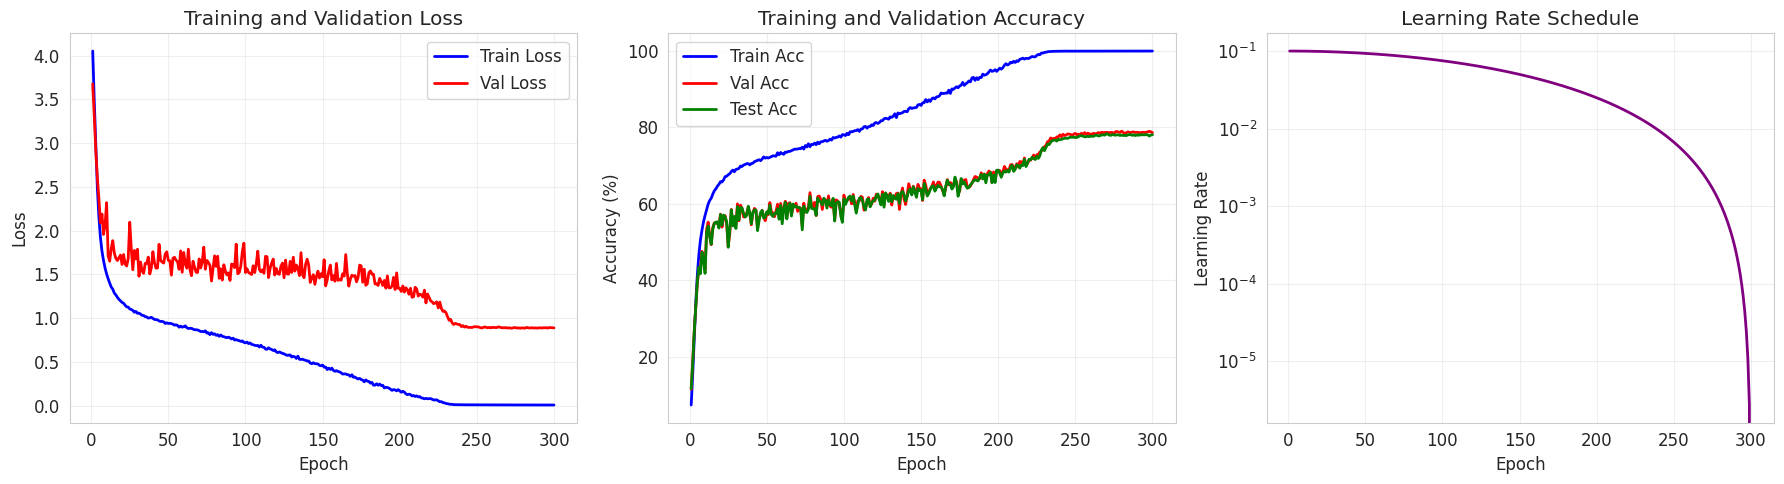

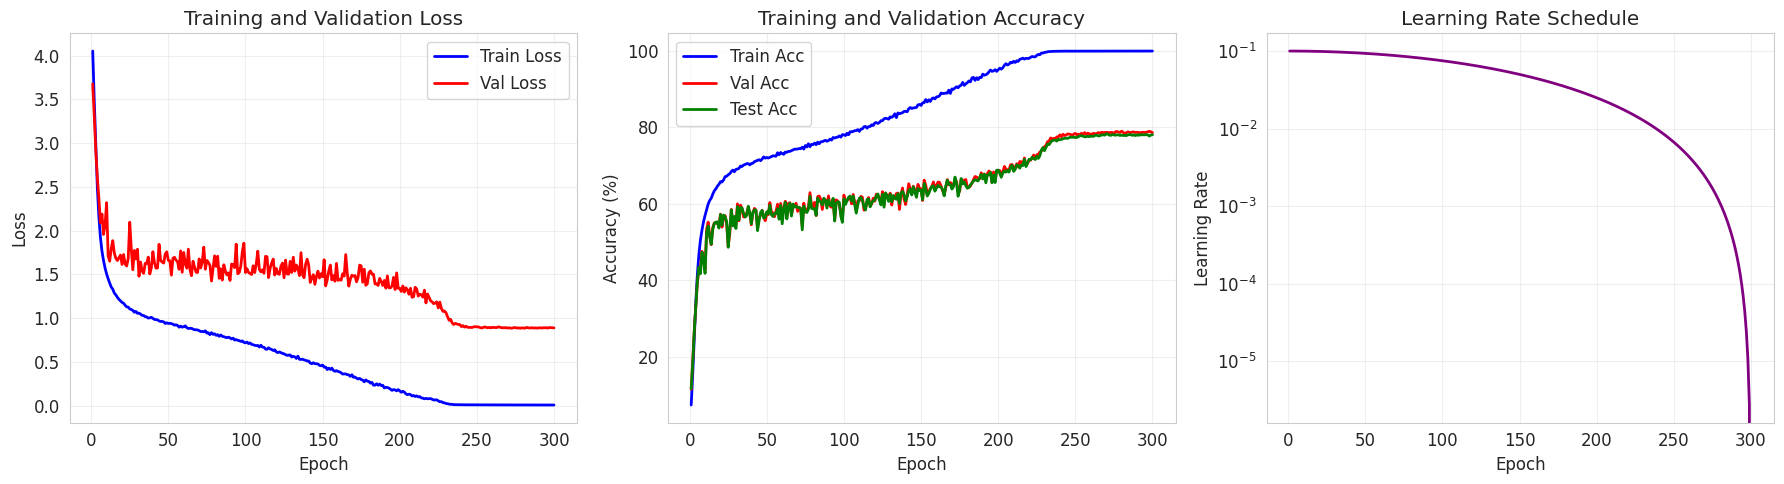

In [10]:
# Plot training curves
curves_path = os.path.join(config['paths']['figures'], 'training', 'training_curves.png')
plot_training_curves(history, save_path=curves_path)

In [12]:
# Create animated GIF (for README)
gif_path = os.path.join(config['paths']['gifs'], 'training_curves.gif')
create_training_gif(history, save_path=gif_path, fps=10)

GIF saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/gifs/training_curves.gif


## 5. Print Final Summary

In [13]:
print("\n" + "=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)

print(f"\nFinal Train Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final Val Accuracy: {history['val_acc'][-1]:.2f}%")
print(f"Final Test Accuracy: {history['test_acc'][-1]:.2f}%")

best_val_acc = max(history['val_acc'])
best_epoch = history['val_acc'].index(best_val_acc) + 1
print(f"\nBest Val Accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")

print(f"\nTotal Epochs: {len(history['train_loss'])}")
print(f"\nCheckpoint saved at: checkpoints/resnet18_cifar100_best.pth")
print(f"Figures saved in: results/figures/training/")
print("\n" + "=" * 60)


TRAINING SUMMARY

Final Train Accuracy: 99.99%
Final Val Accuracy: 78.66%
Final Test Accuracy: 78.10%

Best Val Accuracy: 79.04% (Epoch 280)

Total Epochs: 300

Checkpoint saved at: checkpoints/resnet18_cifar100_best.pth
Figures saved in: results/figures/training/



## 6. Commit Results to GitHub

In [14]:
!git add results/figures/training/
!git add results/figures/gifs/training_curves.gif
!git commit -m "Add Q1 training results: curves and GIF"
!git push

print("Results committed to GitHub!")

fatal: pathspec 'results/figures/training/' did not match any files
fatal: pathspec 'results/figures/gifs/training_curves.gif' did not match any files
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@7a4128002bcd.(none)')
fatal: could not read Username for 'https://github.com': No such device or address
Results committed to GitHub!


In [ ]:
# Checkpoint helpers
import glob
import re
import os


In [ ]:
# Neural Collapse evaluation
from src.neural_collapse.nc_evaluation import evaluate_nc

print("Running Neural Collapse evaluation on validation set...")
metrics_nc = evaluate_nc(model, val_loader, device=device, num_classes=config['model']['num_classes'])
print(metrics_nc)

# Save metrics
metrics_path = os.path.join(config['paths']['metrics'], 'neural_collapse_metrics.yaml')
import yaml
os.makedirs(config['paths']['metrics'], exist_ok=True)
with open(metrics_path, 'w') as f:
    yaml.dump(metrics_nc, f)
print(f"Saved NC metrics to: {metrics_path}")


### Plot Neural Collapse metrics

The cell below plots the NC metrics computed previously and saves the figure to the project's figures folder.

In [ ]:
# Plot NC metrics
import matplotlib.pyplot as plt
import numpy as np

os.makedirs(os.path.join(config['paths']['figures'], 'neural_collapse'), exist_ok=True)
fig_path = os.path.join(config['paths']['figures'], 'neural_collapse', 'nc_metrics.png')

# Select numeric metrics to plot
plot_keys = ['nc1_ratio', 'nc2_avg_off_diagonal_cosine', 'nc2_deviation', 'nc3_alignment', 'nc4_self_duality']
values = [metrics_nc.get(k, np.nan) for k in plot_keys]

plt.figure(figsize=(8,4))
bars = plt.bar(plot_keys, values, color='C0')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Value')
plt.title('Neural Collapse metrics')

# Annotate values
for bar, val in zip(bars, values):
    y = val if not np.isnan(val) else 0
    plt.text(bar.get_x() + bar.get_width()/2, y, f"{val:.3f}" if not np.isnan(val) else 'nan', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"NC metrics plot saved to: {fig_path}")


In [ ]:
# ==============================================================================
# CÉLULAS PARA ADICIONAR AO SEU NOTEBOOK (03_neural_collapse.ipynb)
# ==============================================================================
# Copie estas células para o seu notebook após a seção de treinamento

# %% [markdown]
# ## 7. Neural Collapse Analysis Over Training
# 
# Análise completa das métricas de Neural Collapse usando os checkpoints salvos durante o treinamento.

# %% Cell 1: Import do módulo de análise NC
# ------------------------------------------------------------------------------
# Coloque o arquivo nc_analysis.py na pasta src/neural_collapse/ do seu projeto
# ou adicione ao PYTHONPATH
# ------------------------------------------------------------------------------

import sys
import os

# Adicionar path se necessário
# sys.path.append('/content/OOD-Detection-Project---CSC_5IA23')

# Import do módulo (escolha UMA das opções abaixo)

from src.neural_collapse.nc_analysis import (
    load_checkpoints_and_analyze, 
    plot_nc_evolution, 
    plot_nc_individual,
    save_metrics_yaml,
    NCMetricsTracker
)

print("✅ Módulo de análise NC importado com sucesso!")

# %% Cell 2: Configuração dos caminhos
# ------------------------------------------------------------------------------
checkpoint_dir = config['paths']['checkpoints']
figures_dir = os.path.join(config['paths']['figures'], 'neural_collapse')
metrics_dir = config['paths']['metrics']

# Verificar checkpoints disponíveis
import glob
checkpoints = glob.glob(os.path.join(checkpoint_dir, 'resnet18_cifar100_*.pth'))
print(f"📁 Checkpoints encontrados: {len(checkpoints)}")
for ckpt in sorted(checkpoints)[:5]:
    print(f"   - {os.path.basename(ckpt)}")
if len(checkpoints) > 5:
    print(f"   ... e mais {len(checkpoints) - 5} checkpoints")

# %% Cell 3: Executar análise NC em todos os checkpoints
# ------------------------------------------------------------------------------
# NOTA: Isso pode demorar alguns minutos dependendo do número de checkpoints
# ------------------------------------------------------------------------------

print("🔬 Iniciando análise de Neural Collapse...")
print(f"   Usando: {device}")
print(f"   Classes: {config['model']['num_classes']}")
print()

# Usar train_loader para análise (como no paper original)
# Alternativamente, pode usar val_loader para análise mais rápida

tracker = load_checkpoints_and_analyze(
    checkpoint_dir=checkpoint_dir,
    model_class=ResNet18,
    loader=train_loader,  # ou val_loader para análise mais rápida
    device=device,
    num_classes=config['model']['num_classes'],
    checkpoint_pattern='resnet18_cifar100_*.pth',
    epoch_regex=r'epoch(\d+)',
    verbose=True
)

print("\n" + tracker.summary())

# %% Cell 4: Plotar evolução das métricas NC
# ------------------------------------------------------------------------------
os.makedirs(figures_dir, exist_ok=True)

# Plot principal (todos os gráficos em uma figura)
fig = plot_nc_evolution(tracker, save_dir=figures_dir)
plt.show()

# %% Cell 5: Plots individuais (opcional)
# ------------------------------------------------------------------------------
# Gera figuras separadas para cada métrica (útil para relatórios/papers)

individual_figs = plot_nc_individual(tracker, save_dir=figures_dir)
print(f"📊 {len(individual_figs)} figuras individuais geradas")

# %% Cell 6: Salvar métricas
# ------------------------------------------------------------------------------
os.makedirs(metrics_dir, exist_ok=True)

# Salvar em YAML
yaml_path = os.path.join(metrics_dir, 'nc_evolution_metrics.yaml')
save_metrics_yaml(tracker, yaml_path)

# Também salvar em JSON (opcional)
import json
json_path = os.path.join(metrics_dir, 'nc_evolution_metrics.json')
metrics_dict = tracker.to_dict()

# Converter NaN para None (JSON não suporta NaN)
for key, values in metrics_dict.items():
    if isinstance(values, list):
        metrics_dict[key] = [
            v if not (isinstance(v, float) and np.isnan(v)) else None 
            for v in values
        ]

with open(json_path, 'w') as f:
    json.dump(metrics_dict, f, indent=2)
print(f"💾 Métricas salvas em JSON: {json_path}")

# %% Cell 7: Análise detalhada - Identificar fase de Neural Collapse
# ------------------------------------------------------------------------------
# Neural Collapse tipicamente ocorre na "terminal phase of training"
# quando o modelo atinge ~0% training error

print("\n" + "="*60)
print("ANÁLISE DA FASE DE NEURAL COLLAPSE")
print("="*60)

# Encontrar quando accuracy > 99%
terminal_phase_idx = None
for i, acc in enumerate(tracker.accuracy):
    if acc > 0.99:
        terminal_phase_idx = i
        break

if terminal_phase_idx is not None:
    print(f"\n📌 Terminal Phase detectada na epoch {tracker.epochs[terminal_phase_idx]}")
    print(f"   (accuracy > 99%)")
    print()
    print("Métricas NC no início da Terminal Phase:")
    print(f"   NC1 (Sw/Sb): {tracker.Sw_invSb[terminal_phase_idx]:.4f}")
    print(f"   NC3 (W≈M):   {tracker.W_M_dist[terminal_phase_idx]:.4f}")
    print(f"   NC4 (NCC):   {tracker.NCC_mismatch[terminal_phase_idx]:.4f}")
    print()
    print("Métricas NC no final do treinamento:")
    print(f"   NC1 (Sw/Sb): {tracker.Sw_invSb[-1]:.4f}")
    print(f"   NC3 (W≈M):   {tracker.W_M_dist[-1]:.4f}")
    print(f"   NC4 (NCC):   {tracker.NCC_mismatch[-1]:.4f}")
    
    # Calcular redução
    if not np.isnan(tracker.Sw_invSb[terminal_phase_idx]) and not np.isnan(tracker.Sw_invSb[-1]):
        nc1_reduction = (tracker.Sw_invSb[terminal_phase_idx] - tracker.Sw_invSb[-1]) / tracker.Sw_invSb[terminal_phase_idx] * 100
        print(f"\n📉 Redução NC1: {nc1_reduction:.1f}%")
else:
    print("\n⚠️ Terminal Phase não detectada (accuracy nunca excedeu 99%)")
    print("   O modelo pode precisar de mais epochs de treinamento.")

print("\n" + "="*60)

# %% Cell 8: Verificar correlação entre métricas NC
# ------------------------------------------------------------------------------
import numpy as np
from scipy import stats

print("\n" + "="*60)
print("CORRELAÇÃO ENTRE MÉTRICAS NC")
print("="*60)

# Criar matriz de correlação
metrics_for_corr = {
    'NC1 (Sw/Sb)': tracker.Sw_invSb,
    'NC2 (M CoV)': tracker.norm_M_CoV,
    'NC2 (W CoV)': tracker.norm_W_CoV,
    'NC3 (W-M)': tracker.W_M_dist,
    'NC4 (NCC)': tracker.NCC_mismatch,
}

# Filtrar métricas válidas
valid_indices = []
for i in range(len(tracker.epochs)):
    valid = True
    for key, values in metrics_for_corr.items():
        if np.isnan(values[i]):
            valid = False
            break
    if valid:
        valid_indices.append(i)

if len(valid_indices) > 2:
    print(f"\nUsando {len(valid_indices)} pontos válidos para correlação")
    print()
    
    # Calcular correlações
    metric_names = list(metrics_for_corr.keys())
    print(f"{'':15} " + " ".join([f"{name[:10]:>10}" for name in metric_names]))
    print("-" * 70)
    
    for i, name1 in enumerate(metric_names):
        row = f"{name1[:15]:15}"
        values1 = [metrics_for_corr[name1][idx] for idx in valid_indices]
        
        for j, name2 in enumerate(metric_names):
            values2 = [metrics_for_corr[name2][idx] for idx in valid_indices]
            corr, _ = stats.pearsonr(values1, values2)
            row += f" {corr:10.3f}"
        
        print(row)
else:
    print("\n⚠️ Pontos insuficientes para análise de correlação")

print("\n" + "="*60)

# %% Cell 9: Commit results to GitHub (opcional)
# ------------------------------------------------------------------------------
# !git add {figures_dir}
# !git add {metrics_dir}
# !git commit -m "Add Neural Collapse analysis results"
# !git push
# print("Results committed to GitHub!")